In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")
episodes = episodes.assign(family=episodes.protocol)


def protocol(row):
    if row.family == "nakamoto":
        return "nakamoto"
    elif row.family == "bk":
        return f"bk-{row.k}"
    elif row.family == "tailstorm":
        return f"tailstorm-{row.k}-{row.reward}"
    else:
        assert false


episodes = episodes.assign(protocol=episodes.apply(protocol, axis=1))
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
    episode_eff=lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'batch',
 'learning_rate',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp',
 'episode_eff']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    policies=episodes.query("kind == 'hard-coded'").policy.drop_duplicates().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'policies': ['minor-delay', 'get-ahead', 'honest', 'sapirshtein-2016-sm1'],
 'n_episodes': 100,
 'n_models': 1292}

In [4]:
setting_key = ["protocol", "family", "k", "subblock_selection", "alpha", "gamma"]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,subblock_selection,alpha,gamma
0,bk-8,bk,8,n/a,0.20,0.05
1,bk-8,bk,8,n/a,0.20,0.50
2,bk-8,bk,8,n/a,0.20,0.95
3,bk-8,bk,8,n/a,0.25,0.05
4,bk-8,bk,8,n/a,0.25,0.50
...,...,...,...,...,...,...
67,tailstorm-8-discount,tailstorm,8,heuristic,0.40,0.50
68,tailstorm-8-discount,tailstorm,8,heuristic,0.40,0.95
69,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.05
70,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.50


In [5]:
point_key = setting_key + ["learning_rate", "ent_coef", "shape", "policy"]
rl_episodes = (
    episodes.query('kind == "trained" and not reused')
    .sort_values(point_key)
    .reset_index(drop=True)
)
points = (
    rl_episodes.groupby(point_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
        eff_mean=("episode_eff", np.mean),
        eff_std=("episode_eff", np.std),
    )
    .reset_index()
)
points

,protocol,family,k,subblock_selection,alpha,gamma,learning_rate,ent_coef,shape,policy,n,relrew_mean,relrew_std,rpp_mean,rpp_std,eff_mean,eff_std
0,bk-8,bk,8,n/a,0.20,0.05,0.0001,0.005,raw,ppo-jvnxd03f-best,100,0.200942,0.009109,0.200942,0.009109,1.004708,0.045547
1,bk-8,bk,8,n/a,0.20,0.05,0.0001,0.005,raw,ppo-jvnxd03f-last,100,0.200369,0.009173,0.200369,0.009173,1.001844,0.045866
2,bk-8,bk,8,n/a,0.20,0.05,0.0001,0.010,raw,ppo-0mn82shs-best,100,0.199301,0.009377,0.199301,0.009377,0.996503,0.046887
3,bk-8,bk,8,n/a,0.20,0.05,0.0001,0.010,raw,ppo-0mn82shs-last,100,0.201575,0.008919,0.201575,0.008919,1.007874,0.044595
4,bk-8,bk,8,n/a,0.20,0.05,0.0001,0.050,raw,ppo-ft4l15yw-best,100,0.199506,0.009401,0.199506,0.009401,0.997532,0.047005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95,0.001,0.005,raw,ppo-6pkcv6vl-last,100,0.356931,0.083784,0.330750,0.076672,0.734999,0.170382
1288,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95,0.001,0.010,raw,ppo-8055kqcz-best,100,0.474942,0.098361,0.426655,0.085031,0.948122,0.188958
1289,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95,0.001,0.010,raw,ppo-8055kqcz-last,100,0.194687,0.093997,0.187064,0.090608,0.415698,0.201351
1290,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95,0.001,0.050,raw,ppo-236wrui3-best,100,0.518002,0.030867,0.468310,0.028574,1.040688,0.063497


In [6]:
def save(model):
    if "-best" in model:
        return "best"
    elif "-last" in model:
        return "last"
    elif "_2" in model:
        return "last"
    else:
        raise Exception(model)


points = points.assign(save=[save(x) for x in points.policy])

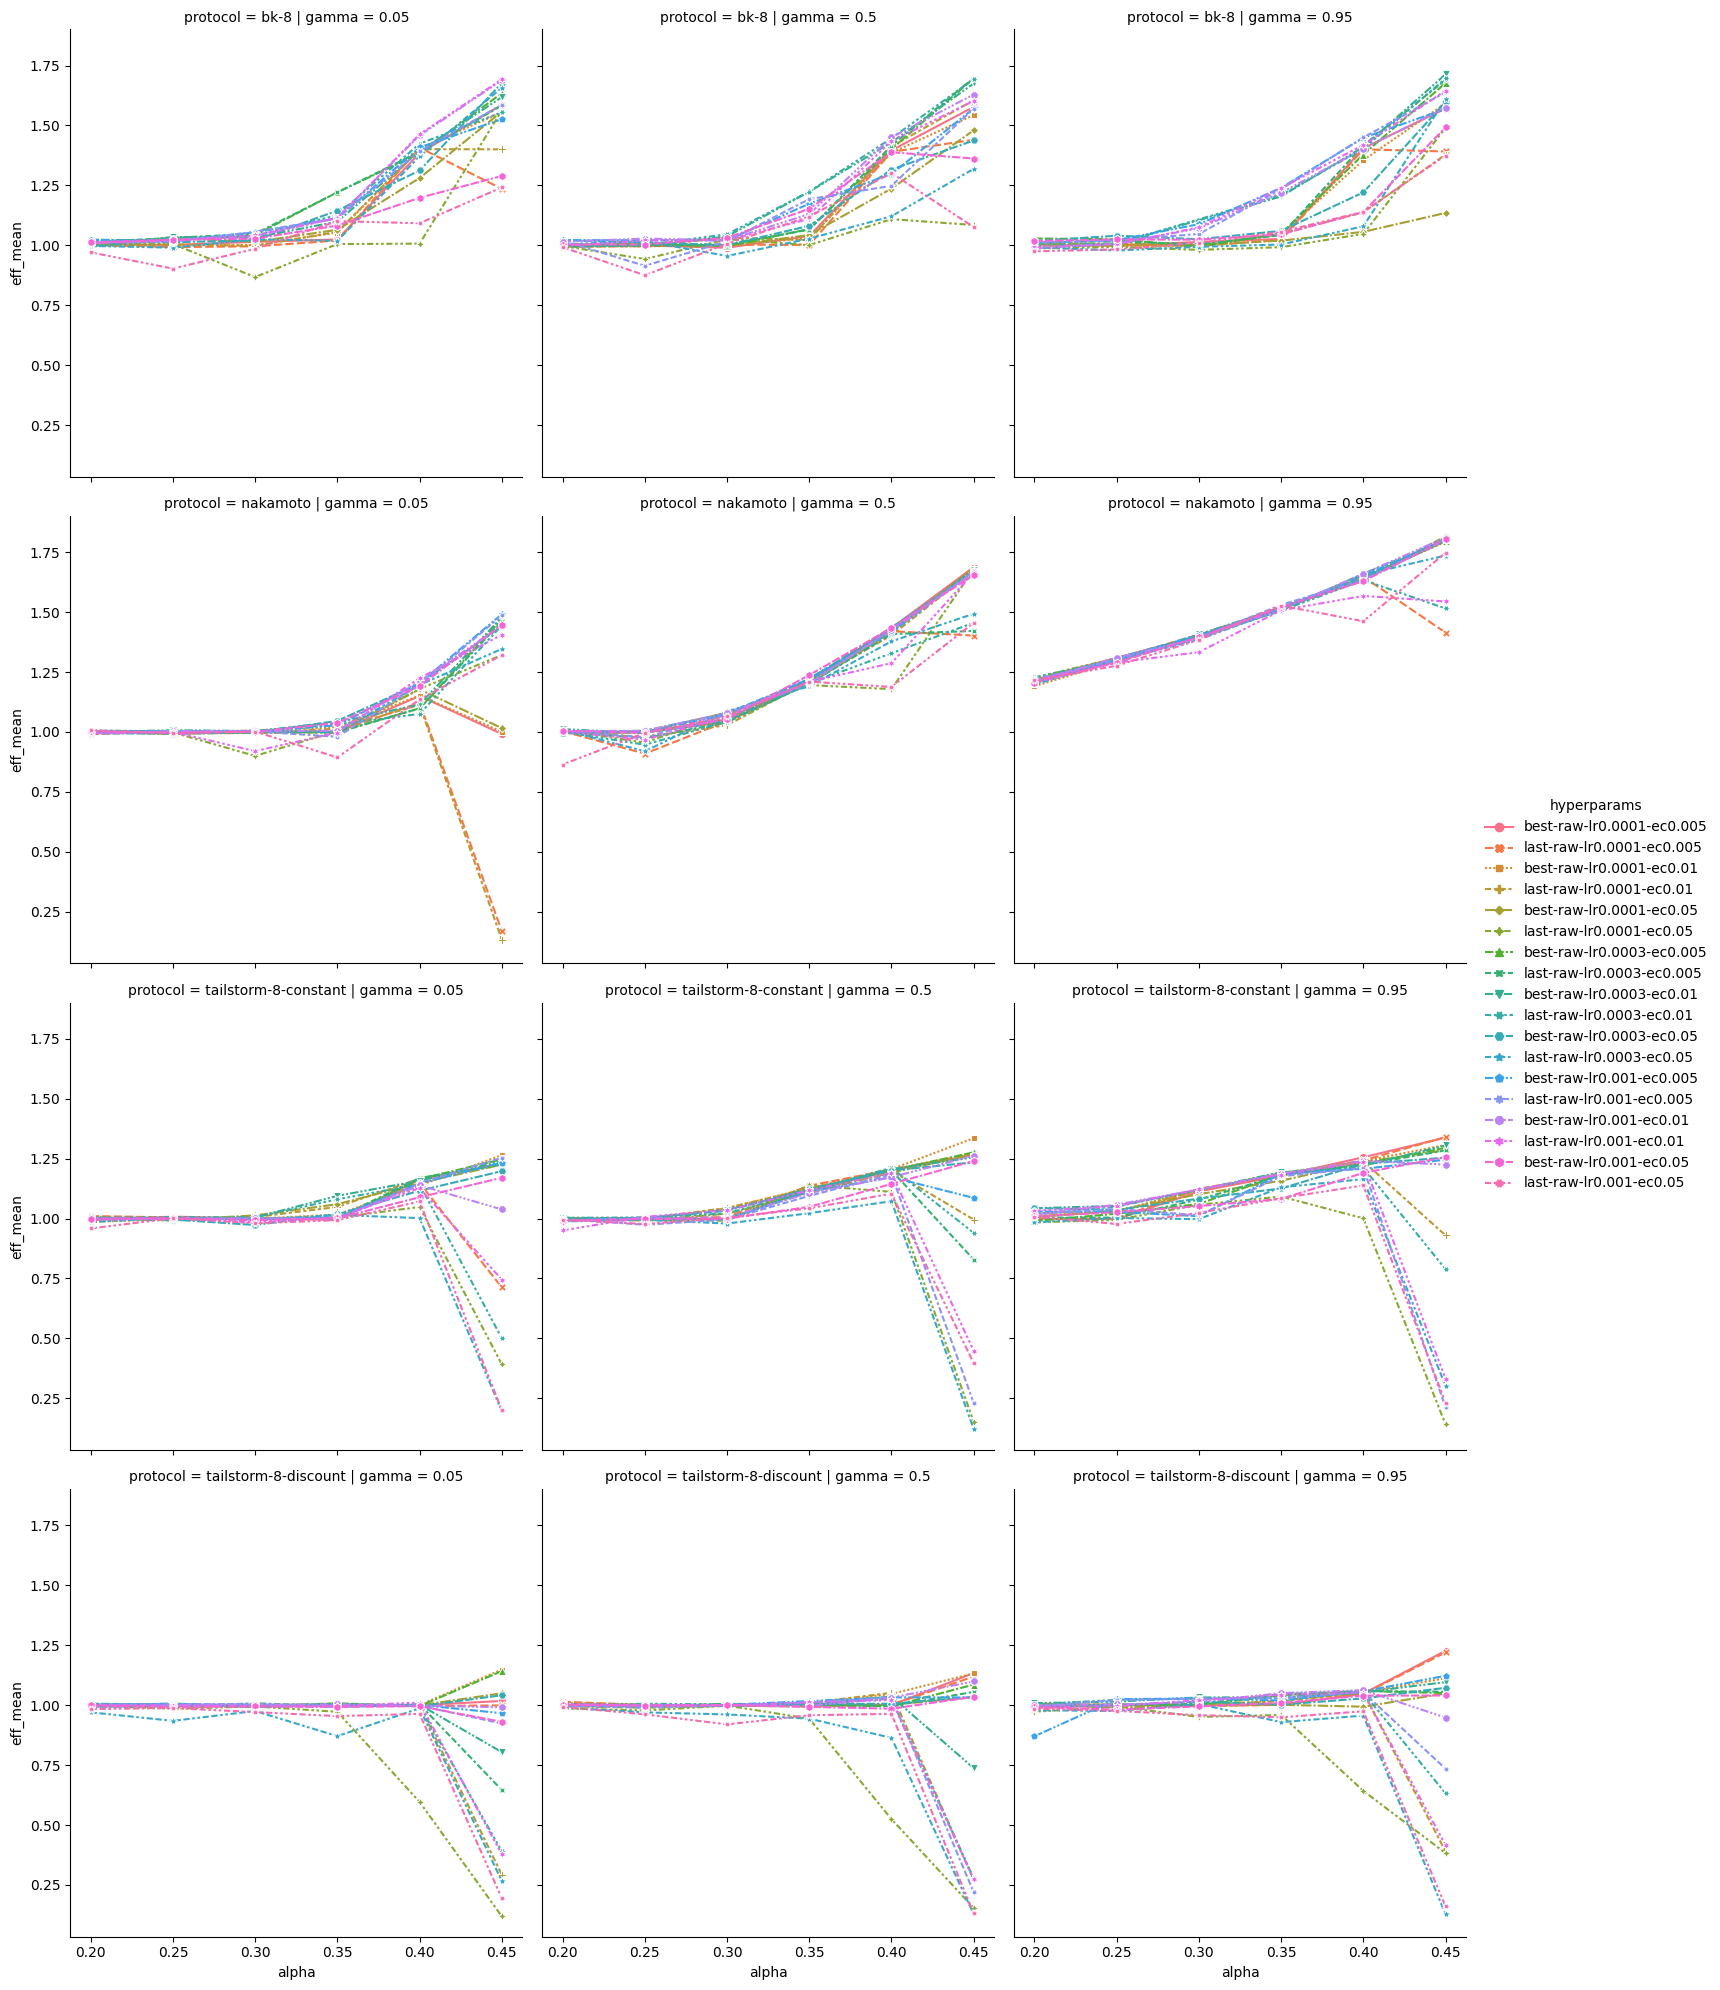

In [7]:
subset = points.assign(
    hyperparams=points.agg(
        "{0[save]}-{0[shape]}-lr{0[learning_rate]}-ec{0[ent_coef]}".format, axis=1
    ),
)
fig = sns.relplot(
    kind="line",
    data=subset,
    y="eff_mean",
    x="alpha",
    col="gamma",
    row="protocol",
    hue="hyperparams",
    style="hyperparams",
    markers=True,
)

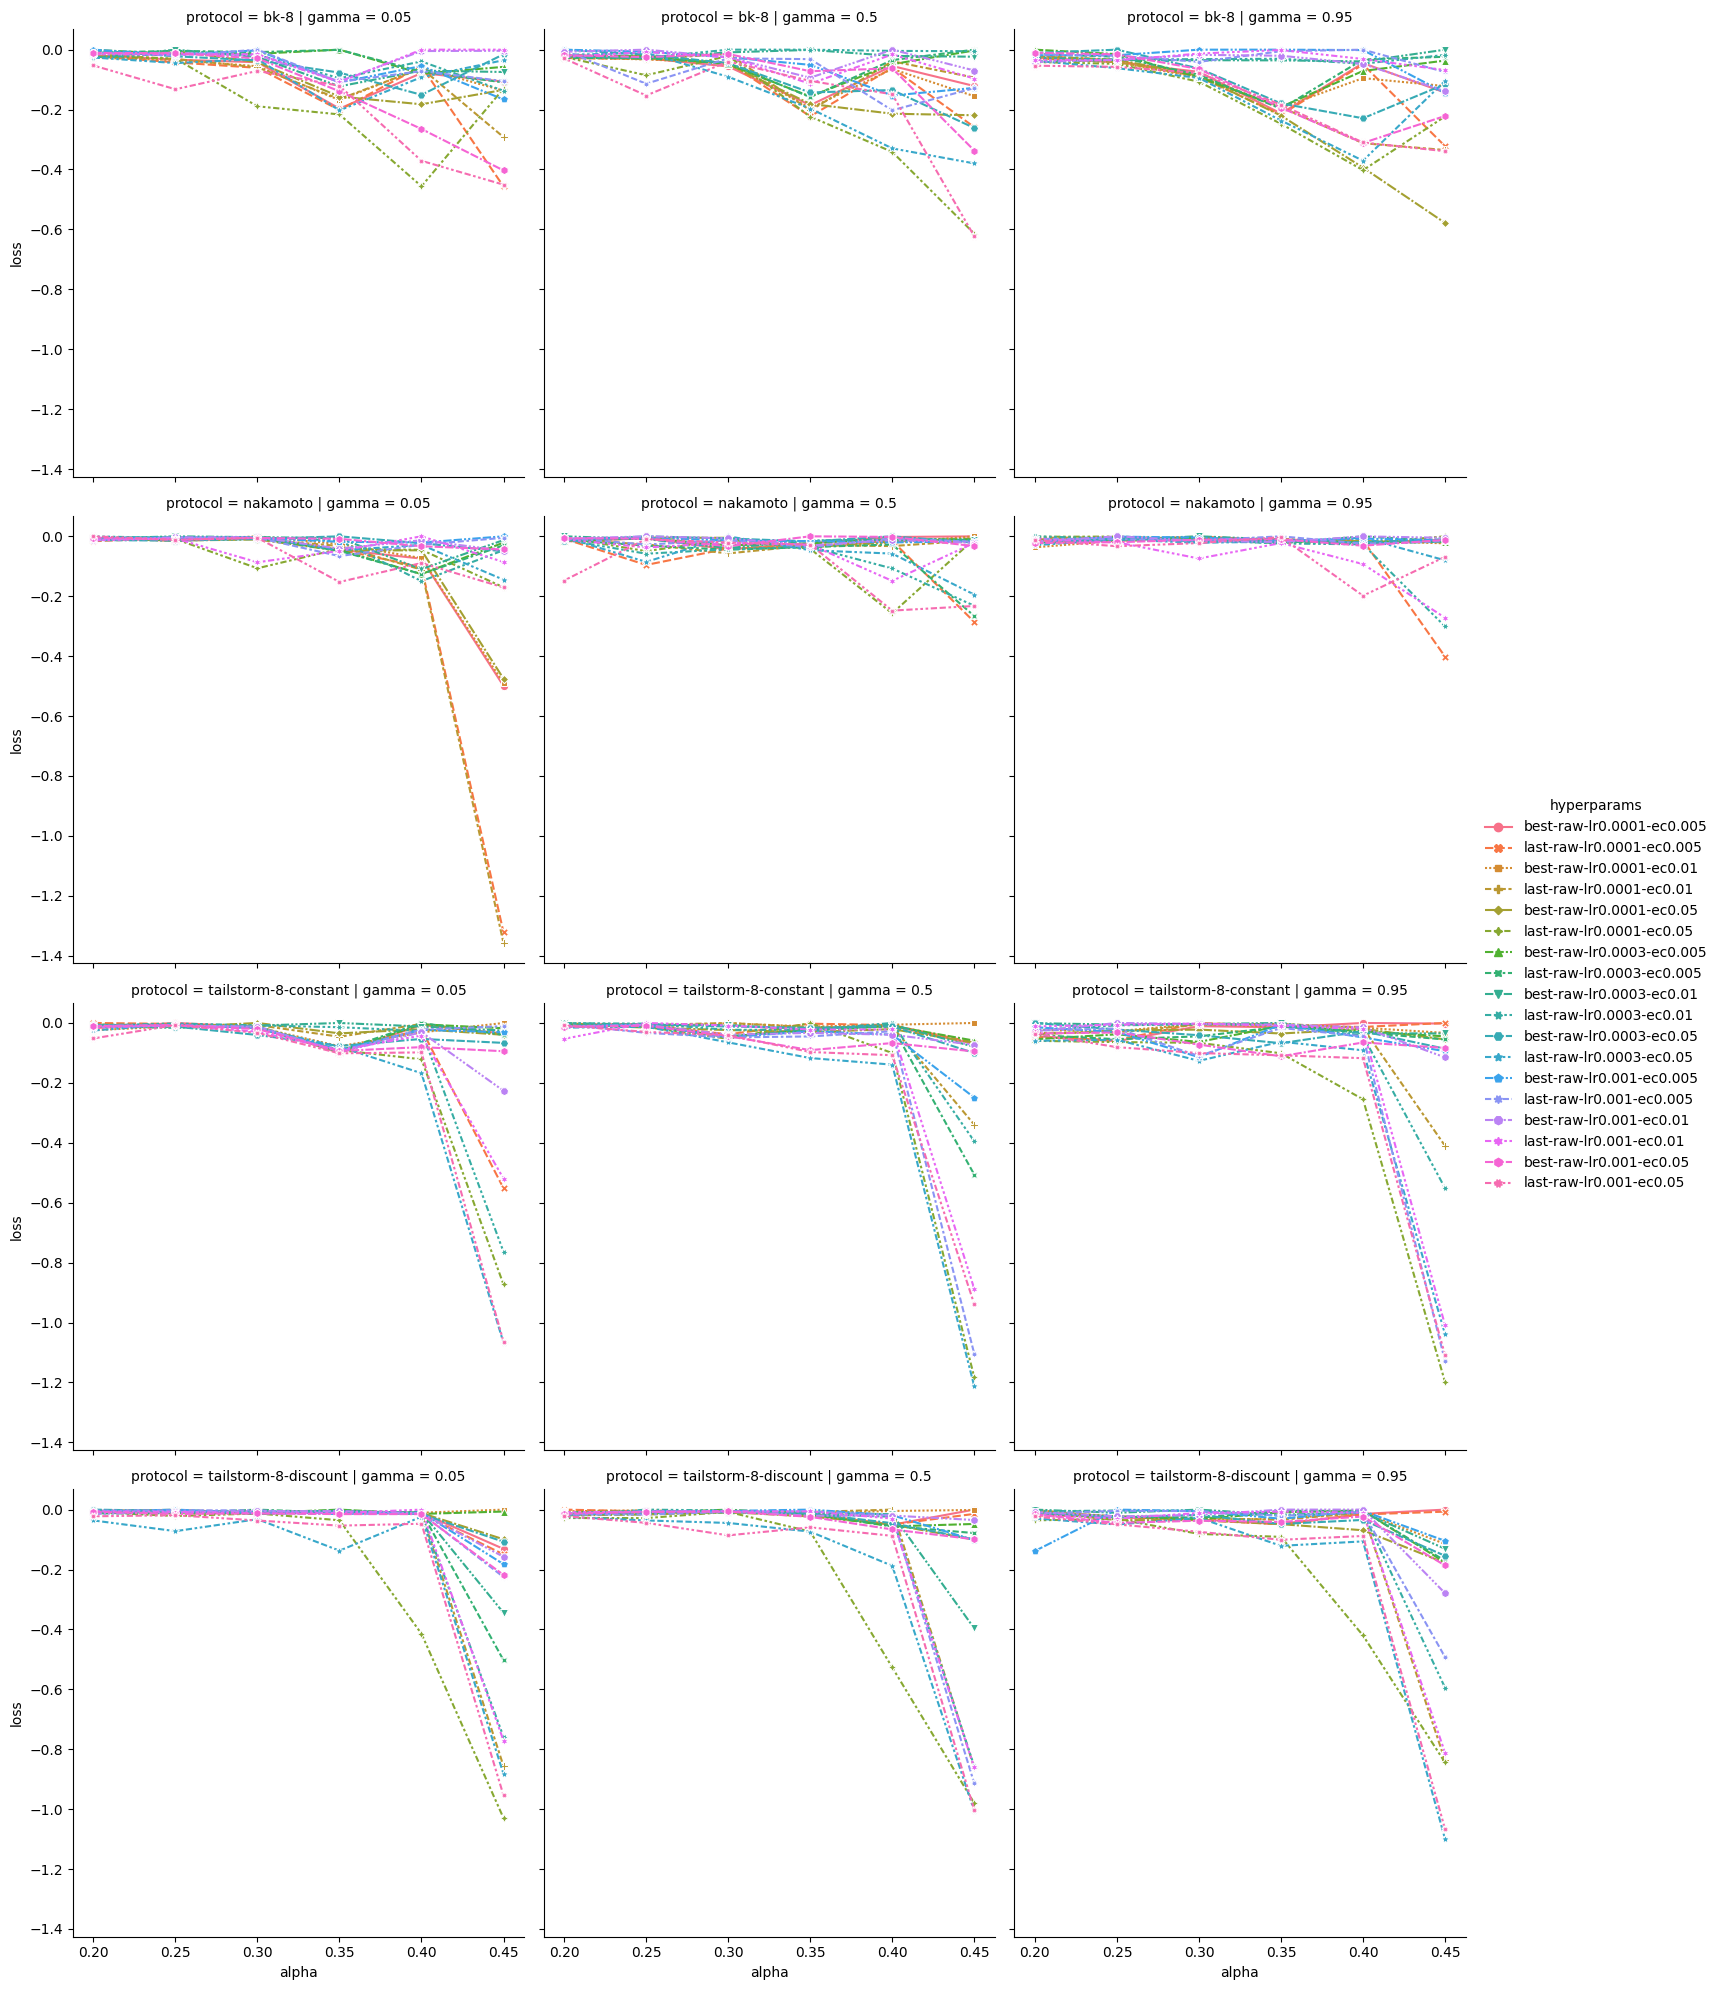

In [8]:
reference = points.groupby(setting_key).agg(max_eff=("eff_mean", "max"))
df0 = points.join(reference, on=setting_key).assign(
    loss=lambda d: d.eff_mean - d.max_eff,
    hyperparams=lambda d: d.agg(
        "{0[save]}-{0[shape]}-lr{0[learning_rate]}-ec{0[ent_coef]}".format, axis=1
    ),
)
fig = sns.relplot(
    kind="line",
    data=df0,
    y="loss",
    x="alpha",
    col="gamma",
    row="protocol",
    hue="hyperparams",
    style="hyperparams",
    markers=True,
)

In [9]:
hyperparams = ["save", "shape", "learning_rate", "ent_coef"]
df0.groupby(hyperparams, as_index=False).agg(
    loss_mean=("loss", np.mean), loss_std=("loss", np.std)
).sort_values("loss_mean")

,save,shape,learning_rate,ent_coef,loss_mean,loss_std
11,last,raw,0.0001,0.050,-0.182109,0.290259
17,last,raw,0.001,0.050,-0.176827,0.278717
14,last,raw,0.0003,0.050,-0.159646,0.283787
10,last,raw,0.0001,0.010,-0.104305,0.236859
16,last,raw,0.001,0.010,-0.097041,0.224706
9,last,raw,0.0001,0.005,-0.084588,0.185537
13,last,raw,0.0003,0.010,-0.082912,0.187112
15,last,raw,0.001,0.005,-0.080961,0.215576
2,best,raw,0.0001,0.050,-0.063362,0.104995
8,best,raw,0.001,0.050,-0.060715,0.083143
